In [1]:
import scripro
import scglue
import anndata
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

## Load data

Load the scRNA-seq data and scATAC-seq data, as well as the SCRIP calculated TF score

In [2]:
miradata = anndata.read_h5ad('/fs/home/xuyunfan/project/scripmulti/mira/trajectory.h5ad')

In [3]:
scrip = pd.read_csv('/fs/home/xuyunfan/data/mira/gse/atac/Mouse/enrichment/SCRIP_enrichment.txt',sep='\t',index_col=0)

In [4]:
atac = sc.read_h5ad('/fs/home/xuyunfan/project/scripmulti/mira/atac_scrip.h5ad')

In [5]:
rna = sc.read_h5ad("/fs/home/xuyunfan/data/mira/shareseq_base_data/rna_data.h5ad")

In [6]:
select_cell = list(set(miradata.to_df().index).intersection(scrip.index).intersection(atac.to_df().index).intersection(rna.to_df().index))

In [7]:
miradata = miradata[select_cell]

In [8]:
atac =  atac[select_cell]

In [9]:
atac_df=atac.to_df()

In [10]:
rna =rna[select_cell]

In [11]:
rna.var_names_make_unique()
rna.var_names = [x.capitalize() for x in rna.var_names]

## Calculate Supercell and markergene

In [12]:
test_data = scripro.Ori_Data(rna,Cell_num=50)

In [13]:
%%time
test_data.get_positive_marker_gene_parallel(cores=4)

CPU times: user 2.02 s, sys: 3.28 s, total: 5.29 s
Wall time: 7.83 s


In [14]:
cellgroup = test_data.adata.obs.loc[:,['new_leiden']]

In [17]:
sc.get.rank_genes_groups_df(test_data.adata, group='0_0', log2fc_min=0.5, pval_cutoff=0.1)

,names,scores,logfoldchanges,pvals,pvals_adj
0,Robo1,33.262318,3.100753,2.210608e-70,8.281822e-67
1,Sox5,31.031414,4.105570,9.752101e-62,2.283454e-58
2,Cux1,30.107073,2.690581,3.416571e-65,9.142745e-62
3,Eda,21.409723,3.492702,2.632037e-43,2.900195e-40
4,Nfib,18.497385,2.344622,3.836717e-38,2.994558e-35
...,...,...,...,...,...
1902,Ddx27,2.153615,0.978330,3.330264e-02,9.880031e-02
1903,Tmc7,2.153065,2.035018,3.337731e-02,9.899046e-02
1904,9930021j03rik,2.152729,0.765872,3.336331e-02,9.896460e-02
1905,Psmb1,2.151586,0.917678,3.346546e-02,9.920478e-02


In [18]:
test_data.adata.obs

,n_genes,celltype,true_cell,leiden,new_leiden
barcode,,,,,
R1.04.R2.48.R3.50.P1.55,672,Medulla,Medulla,4,4_1
R1.36.R2.51.R3.11.P1.55,582,TAC-1,Cortex,1,1_0
R1.56.R2.29.R3.61.P1.53,838,Mix,Matrix,0,0_17
R1.03.R2.55.R3.02.P1.54,609,TAC-1,Cortex,1,1_2
R1.72.R2.16.R3.44.P1.55,751,Hair Shaft-cuticle.cortex,Cortex,1,1_7
...,...,...,...,...,...
R1.59.R2.20.R3.84.P1.56,959,IRS,IRS,2,2_9
R1.45.R2.04.R3.35.P1.55,535,TAC-2,Inner Matrix,6,6_0
R1.02.R2.75.R3.29.P1.55,451,TAC-1,Medulla,1,1_6


## Calculate the landscape of supercell

In [15]:
scripro.dataframe_to_sparse_tsv(atac_df, 'test.tsv')

In [16]:
scripro.get_supercell_fragment(cellgroup,'.','./test.tsv',chunksize = 10000000)

3it [00:40, 13.46s/it]

final


In [17]:
scripro.process_tsv('./supercell_fragment/', 'mm10')

Sort tsv files
Merge tsv files
Convert tsv to bigwig format


In [18]:
share_seq_data = scripro.SCRIPro_Multiome(8,'mm10',test_data)

## Calculate the TF activity score

In [19]:
%%time
share_seq_data.cal_ISD_parallel('./bigwig/')

Processing markers: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [22:20<00:00, 16.76s/it]


CPU times: user 42.2 s, sys: 1min 23s, total: 2min 5s
Wall time: 23min 2s


In [20]:
share_seq_data.get_P_value_matrix()

In [21]:
share_seq_data.get_chip_matrix()

In [22]:
share_seq_data.chip_matrix.values.flatten()

array(['4603', '5980', '41898', ..., '2816', '72397', '48059'],
      dtype=object)

In [23]:
%%time
share_seq_data.get_tf()

CPU times: user 1min 21s, sys: 1.64 s, total: 1min 22s
Wall time: 1min 25s


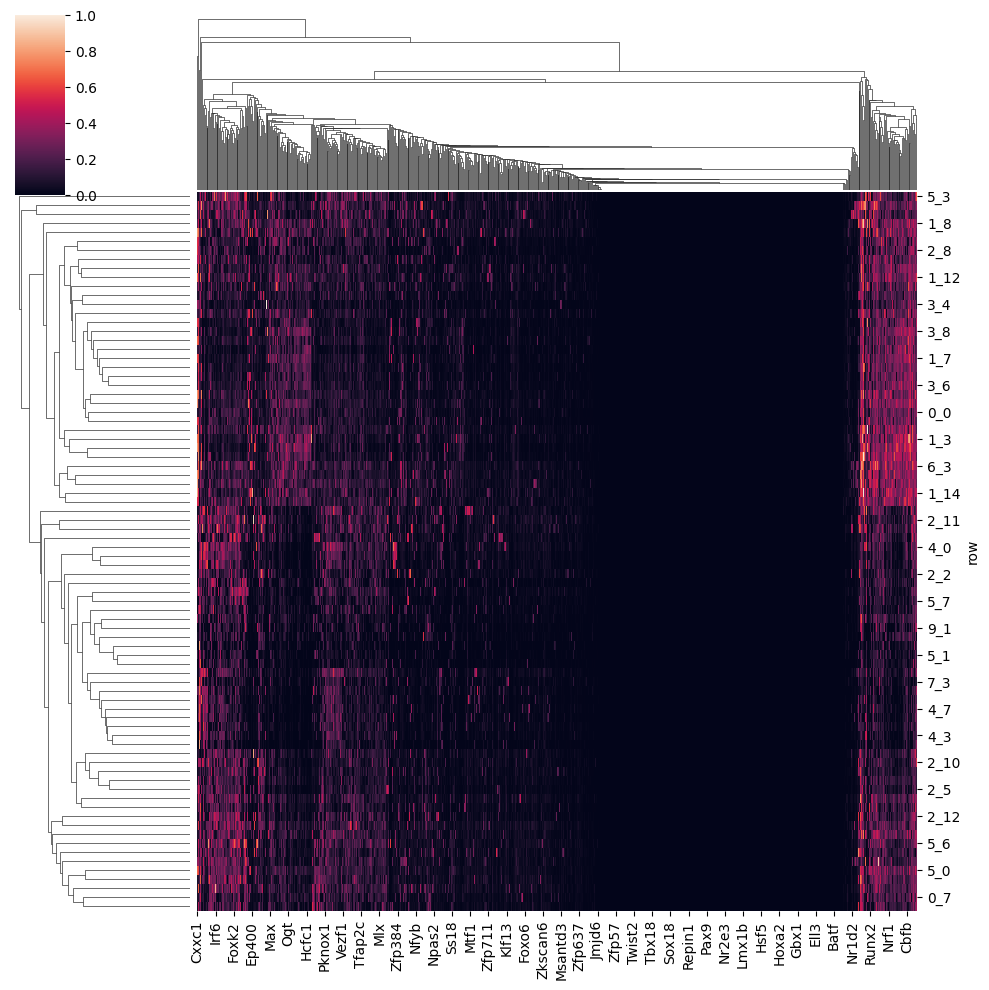

In [24]:
sns.clustermap(share_seq_data.tf_score)

## Calculate the TF activity score corresponding to pesudotime

In [29]:
trajectory_data = sc.read_h5ad('/fs/home/xuyunfan/project/SCRIPro/package/trajectory.h5ad')

In [55]:
all_pro_score = pd.merge(test_data.adata.obs,share_seq_data.tf_score,left_on='new_leiden',right_index=True)

In [56]:
all_pro_score=all_pro_score.iloc[:,5:]

In [30]:
trajectory_data = trajectory_data[select_cell2]

In [57]:
all_pro_score =all_pro_score.loc[trajectory_data.obs.index,:]

In [58]:
all_anndata= sc.AnnData(all_pro_score)

In [59]:
all_anndata.obsm = trajectory_data.obsm

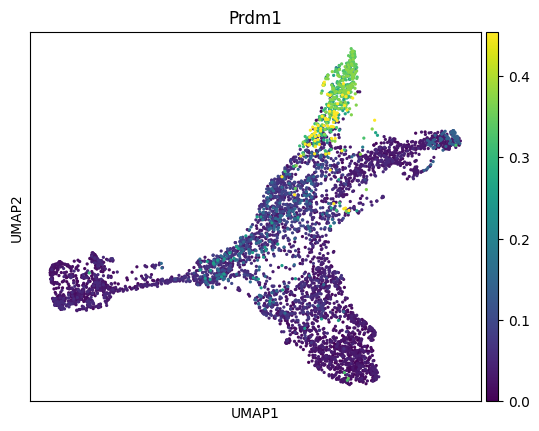

In [66]:
sc.pl.umap(all_anndata,color = 'Prdm1')

## Calculate the difference between the SCRIPro and SCRIP scores corresponding to ORS-Medulla

In [26]:
select_cell2 = list(set(select_cell).intersection(all_pro_score.index))

In [27]:
scrip = (scrip - scrip.min())/(scrip.max()-scrip.min())

In [28]:
scrip = scrip.loc[select_cell2,:]

In [31]:
tra = trajectory_data.obs

In [32]:
Medulla_tra = tra[tra['Medulla_prob'] >0.25].sort_values(by = 'Medulla_prob').index

In [33]:
Medulla_score =all_pro_score.loc[Medulla_tra,:]

In [34]:
Medulla_score.index = Medulla_score['true_cell']

In [35]:
Medulla_score =Medulla_score.iloc[:,5:]

In [36]:
Medulla_score = (Medulla_score - Medulla_score.min())/(Medulla_score.max() - Medulla_score.min())

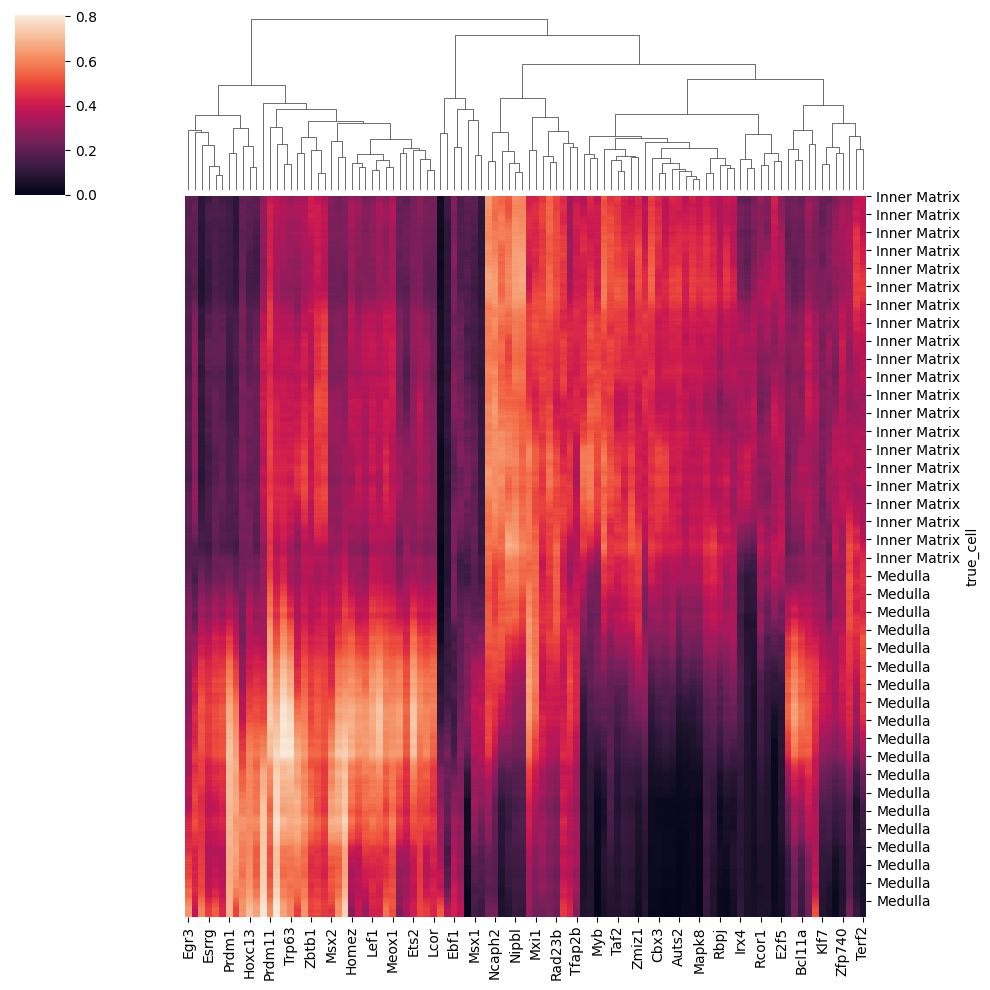

In [37]:
sns.clustermap(Medulla_score.loc[:,Medulla_score.std().sort_values(ascending = False)[0:100].index].rolling(window=100).mean().iloc[100:,:],row_cluster=False)

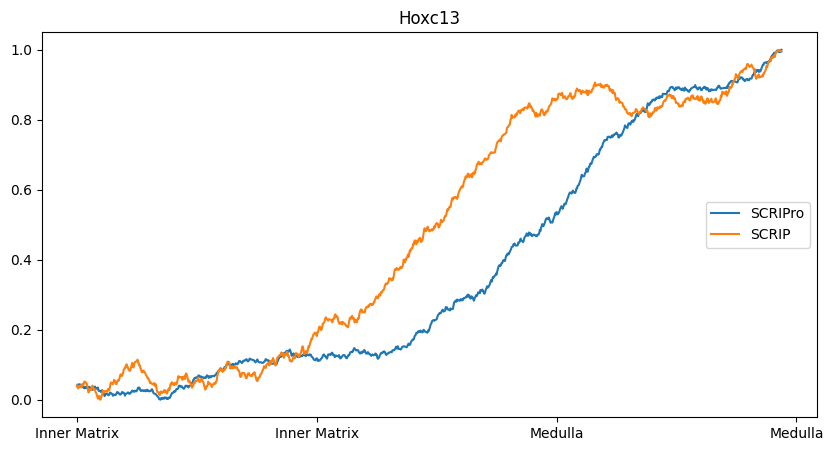

In [38]:
plt.figure(figsize=(10, 5))
TF = 'Hoxc13'
data_series1=pd.Series(list(Medulla_score.loc[:,TF]))
smooth_data1 = data_series1.rolling(window=200).mean()
smooth_data1 = (smooth_data1 - smooth_data1.min())/(smooth_data1.max() - smooth_data1.min())
plt.plot(smooth_data1[200:].reset_index(drop = True), label='SCRIPro')

data_series2=pd.Series(list(scrip.loc[Medulla_tra,TF]))
smooth_data2 = data_series2.rolling(window=200).mean()
smooth_data2 = (smooth_data2 - smooth_data2.min())/(smooth_data2.max() - smooth_data2.min())
plt.plot(smooth_data2[200:].reset_index(drop = True), label='SCRIP')

# set xticks every 200 steps
xticks_locs = np.arange(0, len(Medulla_score.index), 400)
plt.xticks(xticks_locs, Medulla_score.index[xticks_locs])
plt.title(TF)
plt.legend(loc='right')


plt.show()